In [4]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [5]:
class EnhancedSoftClustering:
    def __init__(self, n_clusters=3, m=2.0, alpha=0.5, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.m = m  # Fuzziness parameter
        self.alpha = alpha  # Hybridization coefficient
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        self.X = X
        n_samples, n_features = X.shape

        # Initialize cluster centers randomly
        np.random.seed(42)
        self.centers = X[np.random.choice(n_samples, self.n_clusters, replace=False)]

        # Initialize membership matrix randomly
        self.membership = np.random.rand(n_samples, self.n_clusters)
        self.membership = self.membership / self.membership.sum(axis=1, keepdims=True)

        for iteration in range(self.max_iter):
            old_centers = self.centers.copy()

            # Update cluster centers
            self.centers = np.array([
                np.sum((self.membership[:, j][:, None] ** self.m) * X, axis=0)
                / np.sum(self.membership[:, j] ** self.m)
                for j in range(self.n_clusters)
            ])

            # Compute distances using hybrid distance measure
            distances = np.zeros((n_samples, self.n_clusters))
            for i in range(n_samples):
                for j in range(self.n_clusters):
                    euclidean_dist = np.linalg.norm(X[i] - self.centers[j])
                    cov_matrix = np.cov(X, rowvar=False)
                    cov_inv = np.linalg.pinv(cov_matrix)
                    mahalanobis_dist = mahalanobis(X[i], self.centers[j], cov_inv)

                    distances[i, j] = (
                        self.alpha * euclidean_dist + (1 - self.alpha) * mahalanobis_dist
                    )

            # Update membership matrix
            for i in range(n_samples):
                for j in range(self.n_clusters):
                    self.membership[i, j] = 1.0 / np.sum(
                        (distances[i, j] / distances[i, :]) ** (2 / (self.m - 1))
                    )

            # Check for convergence
            if np.linalg.norm(self.centers - old_centers) < self.tol:
                break

        return self

    def predict(self):
        return np.argmax(self.membership, axis=1)

    def silhouette_score(self):
        labels = self.predict()
        return silhouette_score(self.X, labels)

In [6]:
# Generate synthetic dataset
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)

# Instantiate and fit the Enhanced Soft Clustering model
clustering = EnhancedSoftClustering(n_clusters=4, alpha=0.5)
clustering.fit(X)

# Evaluate clustering performance
print(f"Silhouette Score: {clustering.silhouette_score():.3f}")

Silhouette Score: 0.618


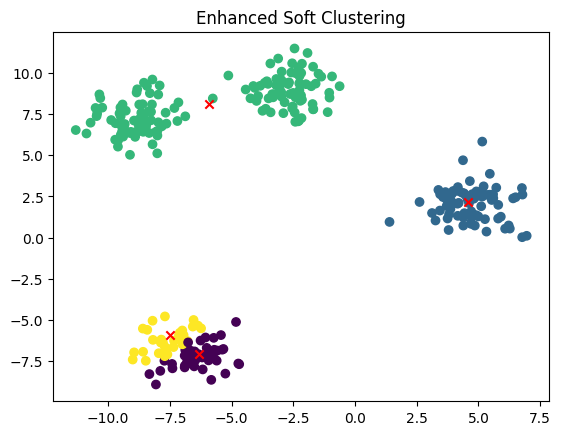

In [8]:
# Visualize clustering results
plt.scatter(X[:, 0], X[:, 1], c=clustering.predict(), cmap="viridis")
plt.scatter(clustering.centers[:, 0], clustering.centers[:, 1], c="red", marker="x")
plt.title("Enhanced Soft Clustering")
plt.show()